In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch

# This has neural network layer primitives that you can use to build things quickly
import torch.nn as nn

# This has things like activation functions and other useful nonlinearities
from torch.nn import functional as F

# This has various gradient descent algorithms
import torch.optim

# In order to take derivatives, we have to wrap things as a Variable or a Parameter.
# Variables are things like inputs to the model
# Parameters are things like weights
# If you make a child class of nn.Module, it automatically keeps tracks of all parameters declared during 
# __init__ for you - really handy!
from torch.autograd import Variable
from torch.nn import Parameter

from IPython import display
import time

Populating the interactive namespace from numpy and matplotlib


## Multi-agent example

Since we can basically optimize parameters of any differentiable program, we can set up all sorts of complex multi-agent things and then optimize their behavior, so long as the entirety of the calculation is a differentiable function.

Of course there's a practical limit to this - when we take the derivative of a chaotic system for example, the derivative of the outcome with respect to the starting position becomes extremely large. For 'recurrent' situations, e.g. cases where we apply the same basic functions many times over, this is a common occurence, and is often referred to as the exploding/vanishing gradients problem. So this is a reason why something might fail. 

However, it turns out that for a lot of cases, as long as you have feedback which is relatively dense in time, you can restrict the gradient calculation to just the last few timesteps and often you will still get pretty good results. However, if that doesn't work, you may have to move to other techniques such as reinforcement learning or evolutionary methods.

For this project, we'll set up something where we have three agents playing a lying game with cooperative and antagonistic elements, show how to train the different agents against different objective functions while still using the overall differentiability of the interaction, and then show how to scale it to large populations.

### Cooperator-Defector Game

For this game, one agent has to choose between two options based on information from two others. The other agents know which the correct option is, but some of them are rewarded for deceiving the first agent and some are rewarded for relaying it correctly. To keep things interesting, the game is iterated a few times, so the deceiver may gain advantage by telling the truth for a period and then switching strategies.

The 'discerning' agent in this game has two external input sequences: suggestions (N-dimensional continuous vectors) from the advising agents, and the results of the last round of the game. The 'advising' agents have as inputs a sequence of correct choices for the current round, and what the 'discerning' agent did last round.  

Furthermore, since we want these agents to figure out behavior over multiple games, the agents internally pass themselves some information from the previous round.

<img src="multiagent1.svg">

### Some things to play with:

- Investigate the kinds of messages sent to convince the discerner of one thing or another
- What if the information to be exchanged is high dimensional, and rather than lying or telling the truth in general, the advisors have certain things they're supposed to lie about and certain things they're supposed to tell the truth about?
- What if you add message channels back from the discerner to the advisors? From the advisors to eachother?
- What if the discerner has to interrogate the advisors specifically, and has partial information about the true solution (so it can 'catch them in a lie' for example)?
- Use nn.LSTMCell for the recurrent parts and compare - does it train more easily?
- Let the advisors decide whether they're going to be truth-tellers or liars, and give them a higher reward for lying successfully when they intend to. 

In [2]:
# Some utility functions

def toFloatVar(x):
    return Variable(torch.FloatTensor(x), requires_grad=False)

def toLongVar(x):
    return Variable(torch.LongTensor(x), requires_grad=False)

# These functions remove parameters from gradient calculation or add them back in 
# since we'll have different objective functions for different interacting nets
def stopGradient(net):
    for param in net.parameters():
        param.requires_grad = False

def restoreGradient(net):
    for param in net.parameters():
        param.requires_grad = True

## Agent neural networks

This time we'll make two neural network classes - one for discerners and one for advisors (interchangeable for liars or truth-tellers). This time, rather than running the network entirely inside the class, we're going to have an external loop which handles passing information back and forth between multiple networks. However, from PyTorch's point of view, this is still just one big function evaluation.

Since all the various network operations are assumed to work on batches of inputs, we're actually going to have these agents play batches of games in parallel. Note that even though they're playing 100 games in parallel, there's no information leaking between the games during a playout, so even if the liar is the same in each of those 100 games, that fact isn't being used by the individual playouts.

In [3]:
class Discerner(nn.Module):
    def __init__(self, messageSize = 4, hiddenSize = 8):
        super(Discerner,self).__init__()
        
        # Since we're going to run this one step at a time, the input is still just a matrix rather 
        # than a sequence. The features should be:
        #
        # - The error associated with the last play
        # - A message from advisor 1 (size messageSize)
        # - A message from advisor 2 (size messageSize)
        # - A hidden state from the last timestep (size hiddenSize)
        # So the input layer size is 1+2*messageSize+hiddenSize
        
        self.layer1 = nn.Linear(1 + 2*messageSize + hiddenSize,64)        
        self.layer2 = nn.Linear(64,64)
        
        # There are two outputs: a decision probability, and a hidden state
        # We want to use two different nonlinearities for these, so lets make two layers here
        
        self.action_layer = nn.Linear(64, 1)
        self.hidden_layer = nn.Linear(64, hiddenSize)
        
        # Each agent will have its own optimizer, so we can train them at cross purposes to each-other
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
        
        # We're going to want to keep track of how many times each network has played the game
        self.samples = 0
    
    # Inputs are two messages and a hidden state
    def forward(self, message1, message2, hidden, lastScore):
        # First stack everything together into a single input
        # For this we use torch.cat(). The first argument is a list of inputs to stack
        # and the second argument is the axis on which to stack them
        # All other dimensions have to be the same size
        
        z = torch.cat([message1, message2, hidden, lastScore], 1)
        
        z = F.relu(self.layer1(z))
        z = F.relu(self.layer2(z))
        
        # The action will be a probability of answering '1' versus answering '0'
        #
        # We use a probability rather than a discrete action to make everything differentiable
        # This is a very frequent technique for making discrete things work with neural networks, 
        # often called the 'reparameterization trick'
        
        action = F.sigmoid(self.action_layer(z))
        
        # A saturating nonlinearity on the hidden state can help prevent the network's activations from
        # growing in amplitude over time. Generally saturating nonlinearities come at a cost of worse
        # gradient propagation though, so use sparingly 
        # (this is why people don't use sigmoid on internal layers any more)
        
        hidden = F.tanh(self.hidden_layer(z))
        
        return action, hidden

In [4]:
class Advisor(nn.Module):
    def __init__(self, messageSize = 4, hiddenSize = 8):
        super(Advisor,self).__init__()
        
        # For the advisor, the inputs are:
        # - What the Discerner did last round
        # - The 'label' - that is to say, what the Discerner should ideally do this round
        # - The Advisor's hidden state
        # So the input layer size is 2 + hiddenSize
        
        self.layer1 = nn.Linear(2 + hiddenSize,64)        
        self.layer2 = nn.Linear(64,64)
        
        # The outputs are a message and a hidden state
        
        self.message_layer = nn.Linear(64, messageSize)
        self.hidden_layer = nn.Linear(64, hiddenSize)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)

        # We're going to want to keep track of how many times each network has played the game
        self.samples = 0
    
    def forward(self, last_action, label, hidden):
        z = torch.cat([last_action, label, hidden], 1)
        
        z = F.relu(self.layer1(z))
        z = F.relu(self.layer2(z))
        
        # We'll saturate both the message and hidden outputs, to keep things 'civil'
        message = F.tanh(self.message_layer(z))        
        hidden = F.tanh(self.hidden_layer(z))
        
        return message, hidden

## Playing the game (in parallel)

Now we'll set up a function to handle the routing between agents during a playout, and to accumulate scores for each of the agents during play so we can do backprop over the whole thing.

In [5]:
def playGame(discerner, advisor1, advisor2, rounds = 10, batchsize = 100, hiddenSize = 8):
    # These networks are designed to stream information, but they need a starting point
    # So we have to initialize these to some defaults
    # We'll choose 0 for initial hidden states and 0.5 for the last action and last score
    lastAction = toFloatVar(0.5 * np.ones((batchsize, 1)))
    lastScore = toFloatVar(0.5 * np.ones((batchsize, 1)))
    
    hiddenDisc = toFloatVar(np.zeros((batchsize, hiddenSize)))
    hiddenAdvisor1 = toFloatVar(np.zeros((batchsize, hiddenSize)))
    hiddenAdvisor2 = toFloatVar(np.zeros((batchsize, hiddenSize)))
    
    # When we accumulate scores for the advisors, we'll assume they're trying to tell the truth, and
    # then if they should be a liar we'll use 1-score for the actual training loss
    # This way playGame() doesn't need to know whether the advisors 'should be' lying or not
    #
    # We'll keep the full sequence of scores, messages, and labels for visualizing the results
    
    scores = []
    messages1 = []
    messages2 = []
    labels = []
    
    for i in range(rounds):
        # Generate the true labels for each game in the batch
        label = toFloatVar(np.random.randint(2, size=(batchsize, 1)))
                
        # Get the messages from the advisors
        message1, hiddenAdvisor1 = advisor1.forward(lastAction, label, hiddenAdvisor1)
        message2, hiddenAdvisor2 = advisor2.forward(lastAction, label, hiddenAdvisor2)
        
        # Get the action from the discerner
        lastAction, hiddenDisc = discerner.forward(message1, message2, hiddenDisc, lastScore)
        
        # Since 'action' is a probability, the expected score can just be calculated directly
        # Even if individual actions are discrete, representing them as probabilities makes things differentiable
        lastScore = lastAction*label + (1-lastAction)*(1-label)        
        
        # Keep track of these scoresfor evaluation/training/reporting
        # We'll add a third dimension to the score tensor so we get sequences of scores
        scores.append(lastScore.unsqueeze(2))
        labels.append(label.unsqueeze(2))
        messages1.append(message1.unsqueeze(2))
        messages2.append(message2.unsqueeze(2))
        
    return torch.cat(scores,2), torch.cat(messages1, 2), torch.cat(messages2, 2), torch.cat(labels, 2)

## Training

Although we're batching sets of games at a time, in each batch the identity of the networks and their role (e.g. advisor #1 and advisor #2) remains constant. So we aren't getting good statistics about factors which we expect to vary in the long run. To correct for this, we're going to collect multiple batches with different network roles before doing a particular training step.

Because gradients accumulate to all parameters when we call .backward(), we have to specify which parameters should be trained against which score. To do this, we'll flip the value of requires_grad to False on parameters we're not training.

Because we want different networks to interact with eachother, we'll define three global populations: a population of Discerners, a population of truth-tellers, and a population of liars. Every time we do a batch, we'll pick a random discerner and choose randomly for each advisor slot whether it's a truth-teller or a liar.

In [6]:
def trainPopulation(nBatches = 1, minSamples = 10):
    global discPop, truthPop, liarPop
    
    for i in range(nBatches):
        agent1 = discPop[np.random.randint(len(discPop))]
        
        isTruthTeller = np.random.randint(2,size=(2,))
        
        if isTruthTeller[0]:
            agent2 = truthPop[np.random.randint(len(truthPop))]
        else:
            agent2 = liarPop[np.random.randint(len(liarPop))]
            
        if isTruthTeller[1]:
            agent3 = truthPop[np.random.randint(len(truthPop))]
        else:    
            agent3 = liarPop[np.random.randint(len(liarPop))]
        
        scores, msg1, msg2, labels = playGame(agent1, agent2, agent3)
        trueLoss = -torch.mean(scores)
        liarLoss = torch.mean(scores)
        
        stopGradient(agent2)
        stopGradient(agent3)
        trueLoss.backward(retain_graph = True)

        stopGradient(agent1)
        restoreGradient(agent2)
        
        if isTruthTeller[0]:
            trueLoss.backward(retain_graph = True)
        else:
            liarLoss.backward(retain_graph = True)
            
        stopGradient(agent2)
        restoreGradient(agent3)
        
        if isTruthTeller[1]:
            trueLoss.backward()
        else:
            liarLoss.backward()
        
        restoreGradient(agent1)
        restoreGradient(agent2)
        
        agent1.samples += 1
        agent2.samples += 1
        agent3.samples += 1
                
    for net in discPop + truthPop + liarPop:
        if net.samples >= minSamples:
            net.optimizer.step()
            net.zero_grad()
            net.samples = 0    

In [7]:
# Initialize populations. Lets just do one of each for speed, but you can increase this
discPop = [ Discerner() for i in range(1) ]
liarPop = [ Advisor() for i in range(1) ]
truthPop = [ Advisor() for i in range(1) ]

tt_score = []
tf_score = []
ft_score = []
ff_score = []

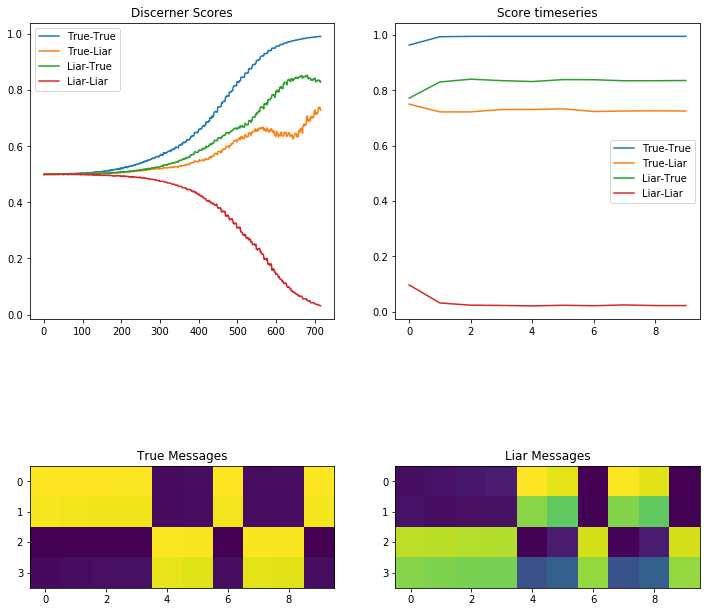

KeyboardInterrupt: 

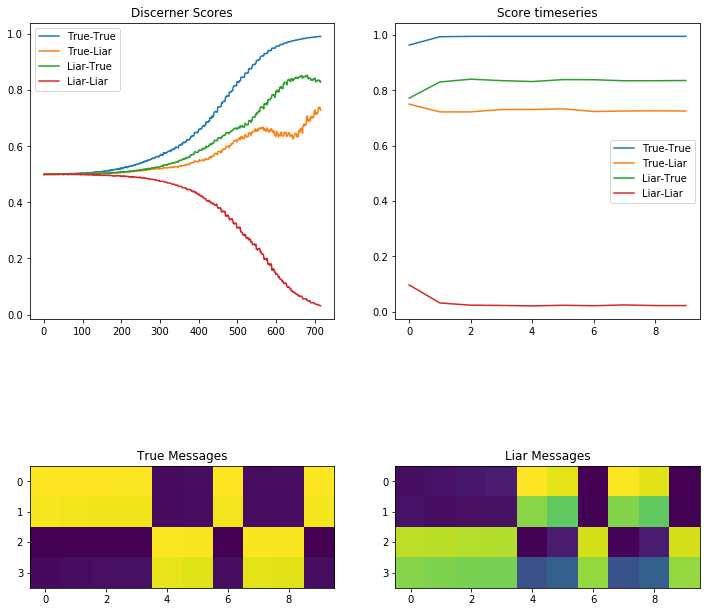

In [8]:
for epoch in range(1900):
    trainPopulation()
    
    # Lets do examples of a true-true, true-liar, liar-true, and liar-liar game for visualization
    tt_scores, tt_msg1, tt_msg2, tt_labels = playGame(discPop[0], truthPop[0], truthPop[0])
    tf_scores, tf_msg1, tf_msg2, tf_labels = playGame(discPop[0], truthPop[0], liarPop[0])
    ft_scores, ft_msg1, ft_msg2, ft_labels = playGame(discPop[0], liarPop[0], truthPop[0])
    ff_scores, ff_msg1, ff_msg2, ff_labels = playGame(discPop[0], liarPop[0], liarPop[0])
    
    tt_score.append(np.mean(tt_scores.data.numpy()))
    tf_score.append(np.mean(tf_scores.data.numpy()))
    ft_score.append(np.mean(ft_scores.data.numpy()))
    ff_score.append(np.mean(ff_scores.data.numpy()))
        
    # This is all plotting stuff
    plt.clf()
    plt.subplot(2,2,1)
    plt.title("Discerner Scores")
    plt.plot(tt_score, label="True-True")
    plt.plot(tf_score, label="True-Liar")
    plt.plot(ft_score, label="Liar-True")
    plt.plot(ff_score, label="Liar-Liar")
    plt.legend()
        
    plt.subplot(2,2,2)
    plt.title("Score timeseries")
    plt.plot(np.mean(tt_scores.data.numpy(),axis=0)[0], label="True-True")
    plt.plot(np.mean(tf_scores.data.numpy(),axis=0)[0], label="True-Liar")
    plt.plot(np.mean(ft_scores.data.numpy(),axis=0)[0], label="Liar-True")
    plt.plot(np.mean(ff_scores.data.numpy(),axis=0)[0], label="Liar-Liar")
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.title("True Messages")
    plt.imshow(tf_msg1.data.numpy()[0])
    
    plt.subplot(2,2,4)
    plt.title("Liar Messages")
    plt.imshow(tf_msg2.data.numpy()[0])
    
    plt.gcf().set_size_inches((12,12))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

plt.clf()